# 1. 天猫复购预测背景

商家有时会在特定日期，例如Boxing-day，黑色星期五或是双十一（11月11日）开展大型促销活动或者发放优惠券以吸引消费者，然而很多被吸引来的买家都是一次性消费者，这些促销活动可能对销售业绩的增长并没有长远帮助，因此为解决这个问题，商家需要识别出哪类消费者可以转化为重复购买者。通过对这些潜在的忠诚客户进行定位，商家可以大大降低促销成本，提高投资回报率（Return on Investment, ROI）。众所周知的是，在线投放广告时精准定位客户是件比较难的事情，尤其是针对新消费者的定位。不过，利用天猫长期积累的用户行为日志，我们或许可以解决这个问题。


# 2. 需求分析 
我们提供了一些商家信息，以及在“双十一”期间购买了对应产品的新消费者信息。你的任务是预测给定的商家中，哪些新消费者在未来会成为忠实客户，即需要预测这些新消费者在6个月内再次购买的概率。

# 3. 数据集描述


数据集包含了匿名用户在 "双十一 "前6个月和"双十一 "当天的购物记录，标签为是否是重复购买者。出于隐私保护，数据采样存在部分偏差，该数据集的统计结果会与天猫的实际情况有一定的偏差，但不影响解决方案的适用性。训练集和测试集数据见文件data_format2.zip，数据详情见下表。

- user_id 购物者的唯一ID编码
- age_range 用户年龄范围。
- gender 用户性别。0表示女性，1表示男性，2和NULL表示未知
- merchant_id 商家的唯一ID编码
- label 取值集合为{0, 1, -1, NULL}。取1表示'userid'是'merchantid'的重复买家，取0则反之。取-1表示'user_id'不是给定商家的新客户，因此不在我们预测范围内，但这些记录可能会提供额外信息。测试集这一部分需要预测，因此为NULL。
- activity_log {userid, merchantid}之间的每组交易中都记录有itemid, categoryid, brand_id, time，用#分隔。记录不按任何特定顺序排序。

以"prediction.csv"作为文件名提交，提交格式如下：
- user_id 购物者的唯一ID编码
- merchant_id 商家的唯一ID编码
- prob 给定客户是给定商家的重复购买者的概率，取值在[0, 1]

其他格式数据

我们还以另一种格式提供了相同数据集，可能更方便做特征工程，详情见data_format1.zip文件夹（内含4个文件），数据描述如下。

用户行为日志
- user_id 购物者的唯一ID编码
- item_id 商品的唯一编码
- cat_id 商品所属品类的唯一编码
- merchant_id 商家的唯一ID编码
- brand_id 商品品牌的唯一编码
- time_tamp 购买时间（格式：mmdd）
- action_type 包含{0, 1, 2, 3}，0表示单击，1表示添加到购物车，2表示购买，3表示添加到收藏夹

用户画像
- user_id 购物者的唯一ID编码
- age_range 用户年龄范围。
- gender 用户性别。0表示女性，1表示男性，2和NULL表示未知

训练数据和测试数据
- user_id 购物者的唯一ID编码
- merchant_id 商家的唯一ID编码
- label 包含{0, 1}，1表示重复买家，0表示非重复买家。测试集这一部分需要预测，因此为空。

# 4. 流程分析

## 4.1 特征工程思路：

>聚合特征：
>
>**toB:**  每个品类(或者其他unit)的销量/收藏量/加购量/点击量，渗透率
>
>**toC:**  这个人的总购买量/.../...，当天前一段时间内的购买量/.../...,

>活动辨识：
>
>是否双11（双十一的行为和之前会有很大差距）

>用户信息
>
>分类变量（Gender, age）的编码等


In [1]:
import pandas as pd
train_df = pd.read_csv('data_format1/train_format1.csv')
test_df = pd.read_csv('data_format1/test_format1.csv')
user_info = pd.read_csv('data_format1/user_info_format1.csv')
user_log = pd.read_csv('data_format1/user_log_format1.csv').rename(columns={'seller_id':'merchant_id'})

## 4.2 探索性分析

In [5]:
user_log.head(100)

,user_id,item_id,cat_id,merchant_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2661.0,829,0
1,328862,844400,1271,2882,2661.0,829,0
2,328862,575153,1271,2882,2661.0,829,0
3,328862,996875,1271,2882,2661.0,829,0
4,328862,1086186,1271,1253,1049.0,829,0
...,...,...,...,...,...,...,...
95,328862,42828,1397,3354,883.0,615,0
96,328862,157010,1095,883,1647.0,615,0
97,328862,484676,267,3073,8126.0,1002,2
98,328862,1024236,1577,1138,4104.0,1002,0


### 1 查看用户画像中年龄和性别缺失率

In [24]:
#无效用户剔除
invalid_users = user_info.loc[user_info['age_range'].isna() | user_info['gender'].isna() | (user_info['age_range']==0) | (user_info['gender']==2), 'user_id']
user_info.describe()
user_info.dropna(subset=['age_range','gender'],inplace=True)
user_info=user_info[~((user_info['age_range']==0) | (user_info['gender']==2))]
user_info.describe()

,user_id,age_range,gender
count,317840.000000,317840.000000,317840.000000
mean,212168.950019,3.756425,0.311525
std,122511.940869,1.323918,0.463117
min,1.000000,1.000000,0.000000
25%,106171.250000,3.000000,0.000000
50%,212175.500000,3.000000,0.000000
75%,318236.250000,5.000000,1.000000
max,424168.000000,8.000000,1.000000


### 2 查看用户信息数据的缺失—用户行为日志数据缺失

In [26]:
user_log.describe()
user_log.dropna(subset=['brand_id'],inplace=True)

用户行为日志主要缺失特征为购买品牌的缺失，其他特征均无缺失。

### 3 查看用户画像和历史记录基本数据描述

In [28]:
user_log.describe()

,user_id,item_id,cat_id,merchant_id,brand_id,time_stamp,action_type
count,5.483432e+07,5.483432e+07,5.483432e+07,5.483432e+07,5.483432e+07,5.483432e+07,5.483432e+07
mean,2.121592e+05,5.538555e+05,8.770755e+02,2.470840e+03,4.153348e+03,9.229646e+02,2.839965e-01
std,1.222875e+05,3.221491e+05,4.486180e+02,1.473345e+03,2.397679e+03,1.954433e+02,8.073288e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.110000e+02,0.000000e+00
25%,1.063400e+05,2.731430e+05,5.550000e+02,1.151000e+03,2.027000e+03,7.300000e+02,0.000000e+00
50%,2.126580e+05,5.555290e+05,8.210000e+02,2.459000e+03,4.065000e+03,1.010000e+03,0.000000e+00
75%,3.177530e+05,8.306860e+05,1.252000e+03,3.760000e+03,6.196000e+03,1.109000e+03,0.000000e+00
max,4.241700e+05,1.113166e+06,1.671000e+03,4.995000e+03,8.477000e+03,1.112000e+03,3.000000e+00


In [29]:
user_info.describe()

,user_id,age_range,gender
count,317840.000000,317840.000000,317840.000000
mean,212168.950019,3.756425,0.311525
std,122511.940869,1.323918,0.463117
min,1.000000,1.000000,0.000000
25%,106171.250000,3.000000,0.000000
50%,212175.500000,3.000000,0.000000
75%,318236.250000,5.000000,1.000000
max,424168.000000,8.000000,1.000000


用户画像的基本数据分析显示用户的平均年龄在30岁左右，且方差较大。且购买者的性别主要为女性。



### 4 查看样本label比例

In [31]:
train_df.describe()

,user_id,merchant_id,label
count,260864.000000,260864.000000,260864.000000
mean,211889.321420,2540.292363,0.061151
std,122399.488027,1451.207514,0.239607
min,1.000000,2.000000,0.000000
25%,105488.000000,1340.000000,0.000000
50%,211927.500000,2482.000000,0.000000
75%,317670.500000,3898.000000,0.000000
max,424170.000000,4993.000000,1.000000


样本不均衡，非重复购买者比例远远大于重复购买者，因此需要采取一定措施解决此类样本不平衡问题

### 5 对top 5店铺进行画图分析

In [32]:
merchant_count=train_df.groupby('merchant_id')['user_id'].nunique().reset_index()
merchant_count=merchant_count.sort_values(by='user_id',ascending=False).head(5)
top5=train_df[train_df['merchant_id'].isin(merchant_count['merchant_id'])]

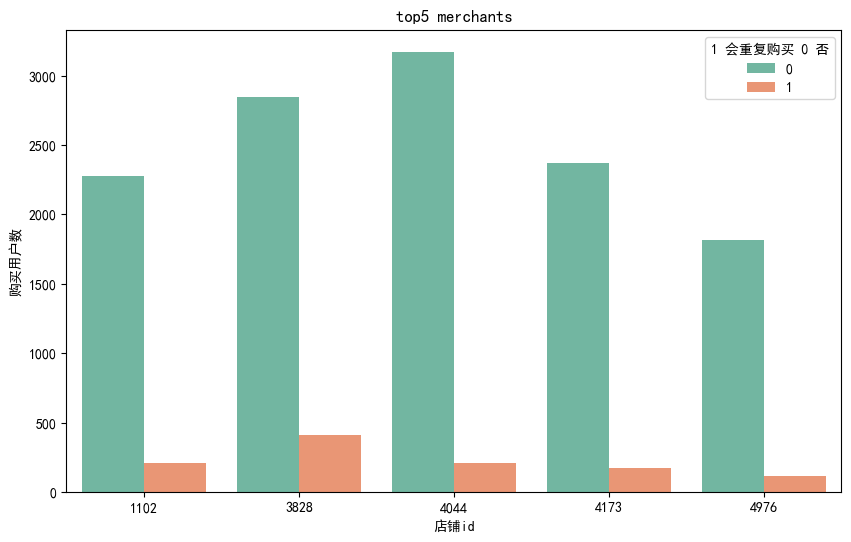

In [36]:
#绘图
from matplotlib import pyplot as plt
import seaborn as sns

plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

plt.figure(figsize=(10,6))
sns.countplot(data=top5,x='merchant_id',hue='label',palette='Set2')

plt.title('top5 merchants')
plt.xlabel('店铺id')
plt.ylabel('购买用户数')
plt.legend(title='1 会重复购买 0 否')

采用分布直方图对前五名店铺进行比例分析，可得前五名店铺占据了接近一半的数据量，且重复购买的比例都远远小于非重复购买

### 6 对商家的重复购买比例进行绘图分析

In [52]:
ratio=top5.groupby('merchant_id').apply(lambda x: x[x['label']==1]['user_id'].nunique()/x['user_id'].nunique()).reset_index(name='rat')

In [59]:
ratio.head()

,merchant_id,rat
0,1102,0.083367
1,3828,0.125999
2,4044,0.061853
3,4173,0.068057
4,4976,0.058701


Text(0, 0.5, '复购率')

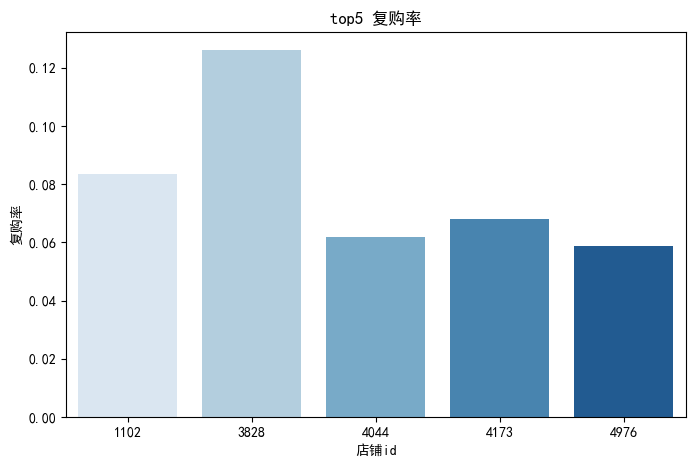

In [61]:
#绘图
plt.figure(figsize=(8, 5))
sns.barplot(data=ratio,x='merchant_id', y='rat',palette='Blues')
plt.title('top5 复购率')
plt.xlabel('店铺id')
plt.ylabel('复购率')

由于数据的特征维度并不具有连续性，无法使用插值法进行填补，并且空缺比率较小，因此我们直接将空缺数据视为一个特征，用-1填补并代表此类特征

### 7 查看离散变量分布
action type中大部分都是click，真正的购买行为很少

In [66]:
user_log.info

<bound method DataFrame.info of           user_id  item_id  cat_id  merchant_id  brand_id  time_stamp  \
0          328862   323294     833         2882    2661.0         829   
1          328862   844400    1271         2882    2661.0         829   
2          328862   575153    1271         2882    2661.0         829   
3          328862   996875    1271         2882    2661.0         829   
4          328862  1086186    1271         1253    1049.0         829   
...           ...      ...     ...          ...       ...         ...   
54925325   208016   107662     898         1346    7995.0        1110   
54925326   208016  1058313     898         1346    7995.0        1110   
54925327   208016   449814     898          983    7995.0        1110   
54925328   208016   634856     898         1346    7995.0        1110   
54925329   208016   272094     898         1346    7995.0        1111   

          action_type  
0                   0  
1                   0  
2                  

In [62]:
user_log.describe()

,user_id,item_id,cat_id,merchant_id,brand_id,time_stamp,action_type
count,5.483432e+07,5.483432e+07,5.483432e+07,5.483432e+07,5.483432e+07,5.483432e+07,5.483432e+07
mean,2.121592e+05,5.538555e+05,8.770755e+02,2.470840e+03,4.153348e+03,9.229646e+02,2.839965e-01
std,1.222875e+05,3.221491e+05,4.486180e+02,1.473345e+03,2.397679e+03,1.954433e+02,8.073288e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.110000e+02,0.000000e+00
25%,1.063400e+05,2.731430e+05,5.550000e+02,1.151000e+03,2.027000e+03,7.300000e+02,0.000000e+00
50%,2.126580e+05,5.555290e+05,8.210000e+02,2.459000e+03,4.065000e+03,1.010000e+03,0.000000e+00
75%,3.177530e+05,8.306860e+05,1.252000e+03,3.760000e+03,6.196000e+03,1.109000e+03,0.000000e+00
max,4.241700e+05,1.113166e+06,1.671000e+03,4.995000e+03,8.477000e+03,1.112000e+03,3.000000e+00


各种行为基本上都是在双十一激增

In [65]:
user_log.value_counts('time_stamp')

time_stamp
1111    10564866
1110     2929056
1109     1202382
1108      964587
1107      854720
          ...   
512        20573
511        19920
518        19127
519        18313
1112          46
Length: 186, dtype: int64

### 8 填充缺失值

# 5 数据处理

## 5.1 特征构造-聚合特征

In [68]:
# 每个用户在每个商家交互过的商品总和（不分种类）。total_item_id
total_item_id=user_log.groupby(['user_id','merchant_id'])['item_id'].count().reset_index(name='total_item_id')
total_item_id.head()

,user_id,merchant_id,total_item_id
0,1,471,1
1,1,739,1
2,1,925,4
3,1,1019,14
4,1,1156,1


In [73]:
# 每个用户在每个商家交互过的商品种类总和。unique_item_id
unique_item_id = user_log.groupby(['user_id', 'merchant_id'])['item_id'].nunique().reset_index(name='unique_item_id')   
unique_item_id.head()

,user_id,merchant_id,unique_item_id
0,1,471,1
1,1,739,1
2,1,925,1
3,1,1019,1
4,1,1156,1


In [74]:
# 每个用户在每个商家交互过的商品所属品类总和total_cat_id
total_cat_id = user_log.groupby(['user_id', 'merchant_id'])['cat_id'].nunique().reset_index(name='total_cat_id')
total_cat_id

,user_id,merchant_id,total_cat_id
0,1,471,1
1,1,739,1
2,1,925,1
3,1,1019,1
4,1,1156,1
...,...,...,...
14052680,424170,1082,1
14052681,424170,3469,1
14052682,424170,3736,2
14052683,424170,4268,1


In [82]:
# 每个用户在每个商家交互过的天数总和。total_time_temp

total_time_temp = user_log.groupby(['user_id', 'merchant_id'])['time_stamp'].nunique().reset_index(name='total_time_temp')

In [77]:
# 每个用户在每个商家点击次数总和。clicks
clicks = user_log[user_log['action_type'] == 0].groupby(['user_id', 'merchant_id'])['action_type'].count().reset_index(name='clicks')

# 每个用户在每个商家加入购物车次数总和。shopping_cart
shopping_cart = user_log[user_log['action_type'] == 1].groupby(['user_id', 'merchant_id'])['action_type'].count().reset_index(name='shopping_cart')


In [89]:
# 合并数据
df_features = total_item_id.merge(unique_item_id, on=['user_id', 'merchant_id'])
df_features = df_features.merge(total_cat_id, on=['user_id', 'merchant_id'])
df_features = df_features.merge(total_time_temp, on=['user_id', 'merchant_id'])
df_features = df_features.merge(clicks, on=['user_id', 'merchant_id'], how='left')
df_features = df_features.merge(shopping_cart, on=['user_id', 'merchant_id'], how='left')

In [91]:
df_train=train_df.merge(df_features,on=['user_id', 'merchant_id'], how='left')

In [92]:
df_train.describe()

,user_id,merchant_id,label,total_item_id,unique_item_id,total_cat_id,total_time_temp,clicks,shopping_cart
count,260864.000000,260864.000000,260864.000000,260811.000000,260811.000000,260811.000000,260811.000000,230991.000000,14.000000
mean,211889.321420,2540.292363,0.061151,10.800549,4.379574,1.878732,1.886719,10.250936,1.071429
std,122399.488027,1451.207514,0.239607,19.807157,7.955462,1.862960,1.666779,19.926362,0.267261
min,1.000000,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,105488.000000,1340.000000,0.000000,3.000000,1.000000,1.000000,1.000000,2.000000,1.000000
50%,211927.500000,2482.000000,0.000000,6.000000,2.000000,1.000000,1.000000,5.000000,1.000000
75%,317670.500000,3898.000000,0.000000,12.000000,4.000000,2.000000,2.000000,11.000000,1.000000
max,424170.000000,4993.000000,1.000000,3918.000000,603.000000,33.000000,56.000000,3917.000000,2.000000


In [101]:
#缺失处理
df_train['clicks'].fillna(0, inplace=True)
df_train['shopping_cart'].fillna(0, inplace=True)
df_train['total_item_id'].fillna(0, inplace=True)
df_train['unique_item_id'].fillna(0, inplace=True)
df_train['total_cat_id'].fillna(0, inplace=True)
df_train['total_time_temp'].fillna(0, inplace=True)
df_train.describe()

,user_id,merchant_id,label,total_item_id,unique_item_id,total_cat_id,total_time_temp,clicks,shopping_cart
count,260864.000000,260864.000000,260864.000000,260864.000000,260864.000000,260864.000000,260864.000000,260864.000000,260864.000000
mean,211889.321420,2540.292363,0.061151,10.798355,4.378684,1.878350,1.886335,9.077044,0.000058
std,122399.488027,1451.207514,0.239607,19.805743,7.954898,1.862963,1.666827,19.032752,0.008072
min,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,105488.000000,1340.000000,0.000000,3.000000,1.000000,1.000000,1.000000,2.000000,0.000000
50%,211927.500000,2482.000000,0.000000,6.000000,2.000000,1.000000,1.000000,4.000000,0.000000
75%,317670.500000,3898.000000,0.000000,12.000000,4.000000,2.000000,2.000000,10.000000,0.000000
max,424170.000000,4993.000000,1.000000,3918.000000,603.000000,33.000000,56.000000,3917.000000,2.000000


## 5.2 下采样

In [102]:
from sklearn.model_selection import train_test_split
x=df_train.drop('label',axis=1)
y=df_train['label']
x_train,y_train,x_test,y_test= train_test_split(x,y,test_size=0.2,random_state=0)

In [100]:
x.describe()

,user_id,merchant_id,total_item_id,unique_item_id,total_cat_id,total_time_temp,clicks,shopping_cart
count,260864.000000,260864.000000,260811.000000,260811.000000,260811.000000,260811.000000,260864.000000,260864.000000
mean,211889.321420,2540.292363,10.800549,4.379574,1.878732,1.886719,9.077044,0.000058
std,122399.488027,1451.207514,19.807157,7.955462,1.862960,1.666779,19.032752,0.008072
min,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,105488.000000,1340.000000,3.000000,1.000000,1.000000,1.000000,2.000000,0.000000
50%,211927.500000,2482.000000,6.000000,2.000000,1.000000,1.000000,4.000000,0.000000
75%,317670.500000,3898.000000,12.000000,4.000000,2.000000,2.000000,10.000000,0.000000
max,424170.000000,4993.000000,3918.000000,603.000000,33.000000,56.000000,3917.000000,2.000000


## 5.3 过采样

In [103]:
#孤立森林减少异常点
from pyod.models.iforest import IForest
clf=IForest(n_estimators=500,behaviour='new',n_jobs=-1)
clf.fit(x[['total_item_id','unique_item_id',"total_cat_id","total_time_temp","clicks","shopping_cart"]])
out_pred=clf.predict_proba(x[['total_item_id','unique_item_id',"total_cat_id","total_time_temp","clicks","shopping_cart"]],method='linear')[:,1]
x['out_pred']=out_pred

D:\wym\tool\anaconda\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


## 5.4 保存数据

In [12]:
train_df.to_csv('train_v1.csv', index=False)
test_df.to_csv('test_v1.csv',index=False)

In [49]:
train_df = pd.read_csv('./train_v1.csv')
test_df = pd.read_csv('./test_v1.csv')

# 6 模型构建和训练&评估

## 6.1 数据准备，评估函数准备

## 6.2 逻辑回归LR
### 1 原始数据

### 2 对样本作平衡处理
调整了一下权重之后效果好多了

### 3 过采样数据训练 

### 4 下采样数据训练

## 6.3 LightGBM

### 1 原始数据

### 2 过采样数据训练

### 3 欠采样数据训练

## 6.4 决策树

## 6.5 XGboost

# 7 输出预测结果
